<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Sergio Daniel Dueñas Godinez y Kaleb Azael Avila Padilla.

**Fecha:** 6 de Febrero del 2024.

**Expediente** : 739300 y .
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/SergioDuenass/Tarea2_SDUENAS_KAVILA 

# Tarea 2: Clase 4

## Enunciado de tarea
> # <span style="color:red"> Tarea 2. </span>

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:

![Screenshot 2024-02-05 at 8.54.42 p.m..png](<attachment:Screenshot 2024-02-05 at 8.54.42 p.m..png>)

In [70]:
# Librerias a utilizar
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import STL

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")
# Leemos los datos
data = pd.read_csv('./dataset/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()

### Código de solución estudiante 1

#### Parte 1

<Axes: >

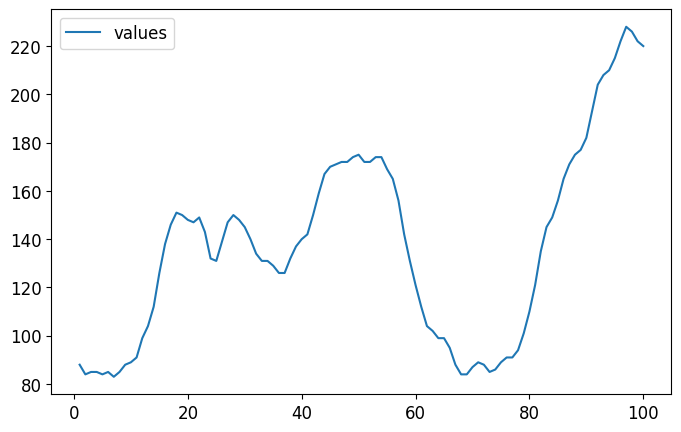

In [26]:
# Código de solución estudiante 1
# Primero quiero ver la gráfica para ver si es estacionario
data.plot(figsize=(8,5))

Veo que si tiene tendencia por lo que no es estacionaria pero verificaré con la función adf_test

In [33]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


adf_test(data)



Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [34]:
# Ahora lo hacemos estacionario haciendo la primera diferenciacion

data_dif1 = data.diff().dropna()

adf_test(data_dif1)

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


vemos que con solo una diferenciacion nos da un p-value muy cercano a nuestro valor critico del .05 por lo que decido quedarme con este

In [43]:
# Realizar el train-test split
# Realizar el train-validation-test split
train_size = int(len(data_dif1) * 0.6)  # 60% de datos para entrenamiento
val_size = int(len(data_dif1) * 0.2)    # 20% de datos para validación
test_size = len(data_dif1) - train_size - val_size

train, test = train_test_split(data_dif1, test_size=test_size, shuffle=False)
train, val = train_test_split(train, test_size=val_size, shuffle=False)


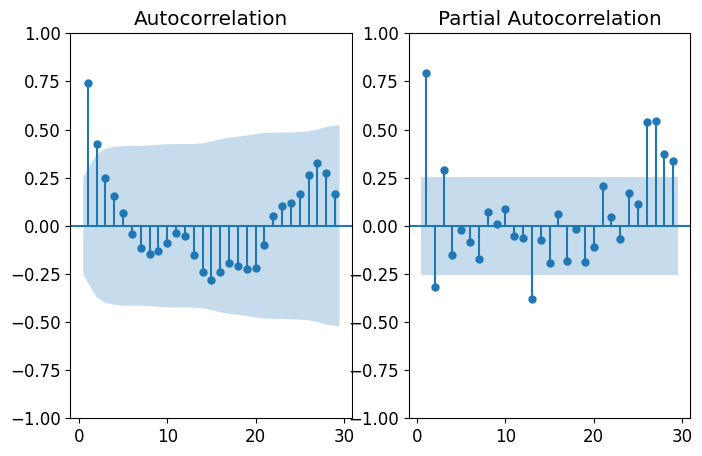

In [50]:
# Graficamos ACF y PACF
# 1. Graficar ACF y PACF
def plot_acf_pacf(s_data, kwargs=dict):
    f = plt.figure(figsize=(8,5))
    ax1 = f.add_subplot(121)
    plot_acf(s_data, zero=False, ax=ax1, **kwargs)
    ax2 = f.add_subplot(122)
    plot_pacf(s_data, zero=False, ax=ax2, method='ols', **kwargs)
    plt.show()

plot_acf_pacf(train, {'lags':29})



Viendo estas gráficas es claro que no se tiene un Moving average porque se tiene un pico muy grande y luego el comportamiento como senoidal. Y para el PACF tenemos 3 puntos en el 0, 1 y 2, por lo que el modelo quedaría ***(p=3,d=1,q=0)***

In [52]:
# Ahora creamos el modelo ARIMA
arima = ARIMA(train, order=(3, 1, 0))
model1 = arima.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   59
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -152.984
Date:                Mon, 05 Feb 2024   AIC                            313.968
Time:                        23:33:15   BIC                            322.209
Sample:                             0   HQIC                           317.178
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.148      1.676      0.094      -0.042       0.537
ar.L2         -0.4232      0.114     -3.696      0.000      -0.648      -0.199
ar.L3          0.0442      0.155      0.285      0.7

Vemos que mejoramos la log verosimilitud al de la clase, ya que teníamos -256.198 y  -248.872 y en este tenemos un -152.984, y para este valor se busca maxearlo por lo que queda mejor y en cuanto al AIC y BIC, en la clase tuvimos para AIC 513.744 y 518.396, y en el nuestro tenemos 313.968, recordando que se busca disminuir estos valores. Para BIC en la clase tuvimos;  526.151,  534.505 y nosotros obtuvimos 322.209. Como se muestra en la siguiente tabla.

| |Log-Verosimilitud | AIC | BIC |
|---|---|---|---|
| model | -152.984 | 313.968 | 322.209 |
| Clase1 | -248.872 | 513.744 | 534.505 |
| Clase2 | -256.198 | 518.396 | 526.151 |

#### Parte 2

In [54]:
# Normalizamos los datos con el MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(data))

In [55]:
# Verificamos si es estacionario
adf_test(scaled)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Vemos que no lo es por lo que diferenciamos

In [56]:
scaled_dif1 = scaled.diff().dropna()
# Realizamos el test de ADF
adf_test(scaled_dif1)

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Podemos analizar que es casi igual a antes de normalizarlos y nos dió buenos resultados. por lo que otra vez usaré lo mismo

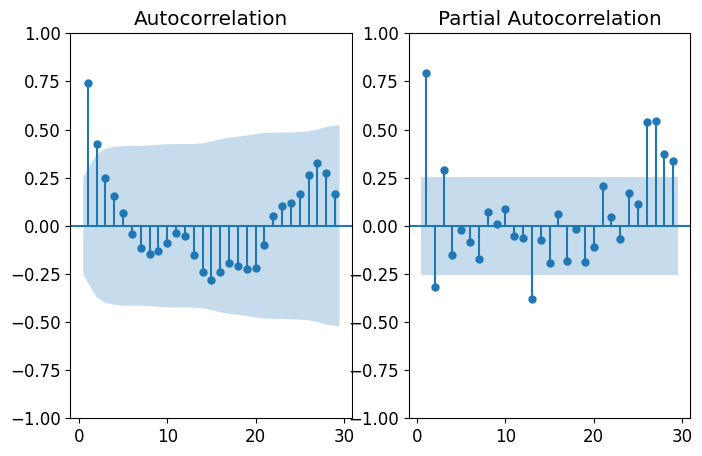

In [57]:
# Dividimos en train, test y validation
train_scaled, test_scaled = train_test_split(scaled_dif1, test_size=test_size, shuffle=False)
train_scaled, val_scaled = train_test_split(train_scaled, test_size=val_size, shuffle=False)

# Vemos las funciones de ACF y PACF
plot_acf_pacf(train_scaled, {'lags':29})

De igual forma me quedaría con (p=3,d=1,q=0)

In [61]:
# Ahora creamos el modelo ARIMA
arima2 = ARIMA(train_scaled, order=(3, 1, 0))
model2 = arima2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   59
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 135.667
Date:                Tue, 06 Feb 2024   AIC                           -263.333
Time:                        00:06:44   BIC                           -255.092
Sample:                             0   HQIC                          -260.123
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2474      0.148      1.675      0.094      -0.042       0.537
ar.L2         -0.4233      0.114     -3.698      0.000      -0.648      -0.199
ar.L3          0.0437      0.155      0.282      0.7

Vemos que mejora mucho en comparación con antes de normalizar

| |Log-Verosimilitud | AIC | BIC |
|---|---|---|---|
| model 1 | -152.984 | 313.968 | 322.209 |
| model 2 | 135.667 | -263.333 | -255.092 |

<Axes: >

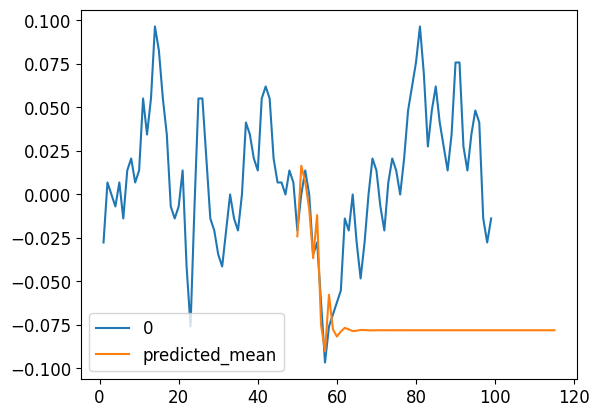

In [68]:
y_h = model2.predict(start=50, end=115).to_frame()
ax = scaled_dif1.plot()
y_h.plot(ax=ax)

#### Parte 3

In [81]:
# Download the data
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))

data2['time'] = data2['time'].astype(int)
data2.index = pd.date_range(start=datetime(data2['time'][0], 1, 1), periods=len(data2), freq='MS')


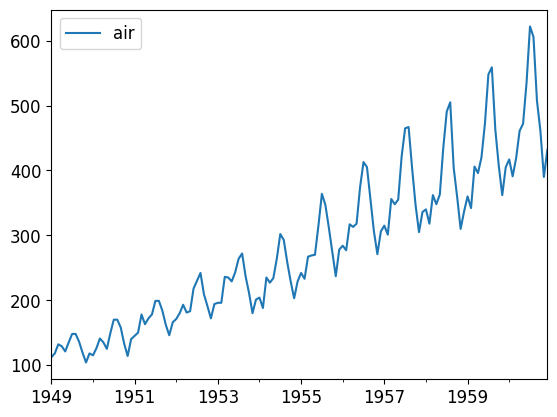

In [82]:
data2 = data2[["air"]]
data2.plot()
plt.show()

Investigando sobre SARIMAX, vi que funciona con series de tiempo con estacionalidad como la que tenemos aquí además de tomar en cuenta variables independientes y ahora además de tomar p,d y q, también pide 𝑚 el cuál, indica al número de períodos en cada temporada.

Test estacionariedad serie original
-------------------------------------
ADF Statistic: 0.8153688792060527, p-value: 0.991880243437641

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -2.8292668241699865, p-value: 0.054213290283827265

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -16.384231542468473, p-value: 2.732891850014397e-29


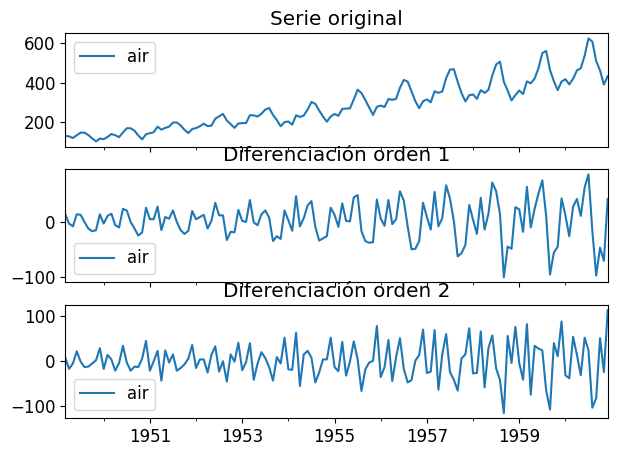

In [87]:
# Test estacionariedad
from statsmodels.tsa.stattools import kpss
data2_diff = data2.diff().dropna()
data2_diff2 = data2.diff().diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(data2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data2_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data2_diff2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data2.plot(ax=axs[0], title='Serie original')
data2_diff.plot(ax=axs[1], title='Diferenciación orden 1')
data2_diff2.plot(ax=axs[2], title='Diferenciación orden 2');

# Referencia de: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

Vemos con solo la primera diferenciación ya queda casi perfecto por lo que me quedaré con esa

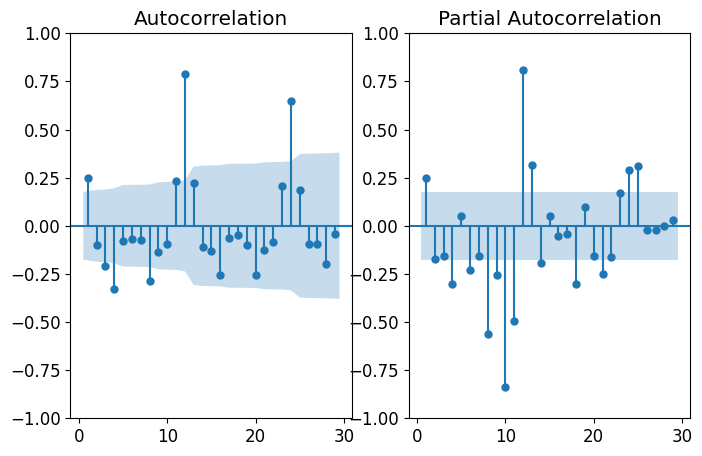

In [88]:
# Dividimos en train, test y validation
train_2, test_2 = train_test_split(data2_diff, test_size=test_size, shuffle=False)
train_2, val_2 = train_test_split(data2_diff, test_size=val_size, shuffle=False)

# Vemos las funciones de ACF y PACF
plot_acf_pacf(train_2, {'lags':29})

Utilizaría p = 1 por el pico en el 1 y en lag 12 de q lo mismo pues tiene un comportamiento similar y la d = 1 ya que solo lleva una diferencial y para la season usé 12 ya que los datos son mensuales por lo que el orden quedaría ***(1,1,1)(1,1,1,12)***

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_ = SARIMAX(endog = train_2, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_sarimax = sarimax_.fit(disp=0)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                air   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -418.448
Date:                            Tue, 06 Feb 2024   AIC                            846.896
Time:                                    01:12:11   BIC                            860.443
Sample:                                02-01-1949   HQIC                           852.392
                                     - 05-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2301      0.097     -2.377      0.017      -0.420      -0.040
ma.L1         -0.9999      5.540     -0.180      0.857     -11.857       9.857
ar.S.L12      -0.9997      0.256     -3.912      0.000      -1.501      -0.499
ma.S.L12       0.9925      3.363      0.295      0.768      -5.598       7.583
sigma2        98.6410    616.866      0.160      0.873   -1110.395    1307.677
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.93   Prob(JB):                         0.89
Heteroskedasticity (H):               1.49   Skew:                             0.02
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

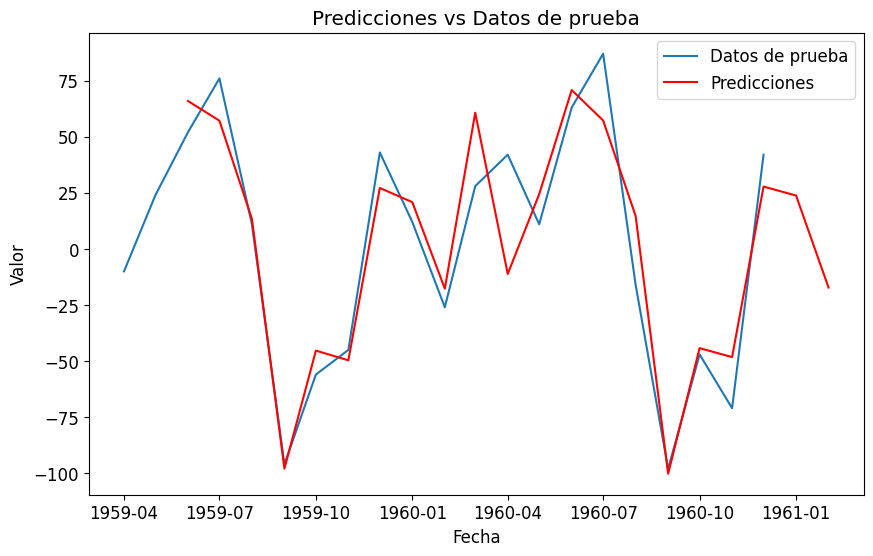

In [100]:
predicciones_statsmodels = model_sarimax.get_forecast(steps=len(test_2)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'

plt.figure(figsize=(10, 6))

# Plot de datos de prueba
plt.plot(test_2, label='Datos de prueba')

# Plot de predicciones
plt.plot(predicciones_statsmodels.index, predicciones_statsmodels, color='red', label='Predicciones')

plt.title('Predicciones vs Datos de prueba')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

#### Parte 4

/var/folders/vj/xp36g_9s7lj2v05vvcsms4500000gn/T/ipykernel_71139/3363462707.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_future = pd.date_range(data2.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')


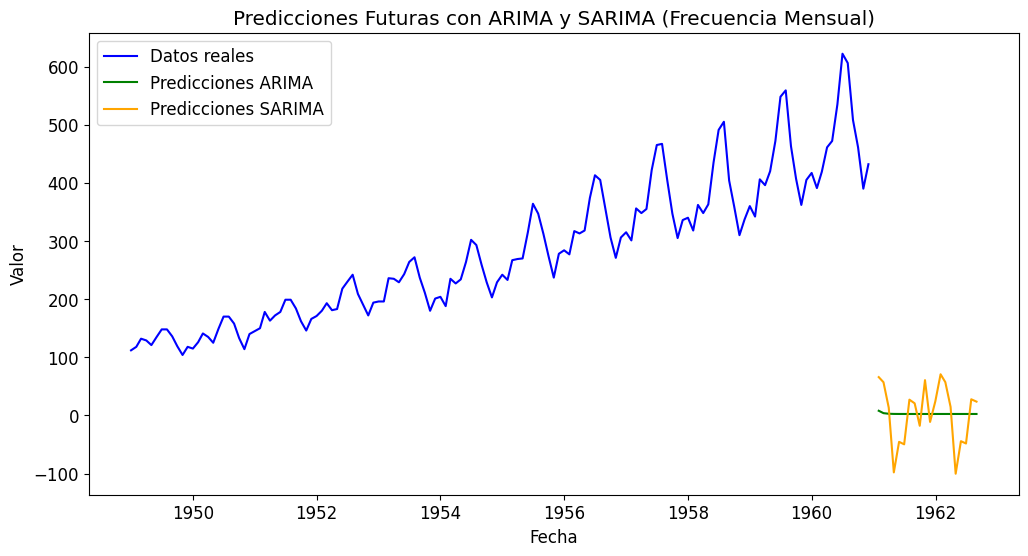

In [103]:
# Entrenar modelo ARIMA
order_arima = (1, 1, 1)  # Reemplaza con los órdenes adecuados
model_arima = ARIMA(train_2, order=order_arima)
results_arima = model_arima.fit()

# Predecir 20 unidades de tiempo en el futuro (meses)
future_steps = 20
index_future = pd.date_range(data2.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='M')

# Predicciones ARIMA
forecast_arima = results_arima.get_forecast(steps=future_steps).predicted_mean

# Predicciones SARIMA
forecast_sarima = model_sarimax.get_forecast(steps=future_steps).predicted_mean

# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(data2.index, data2['air'], label='Datos reales', color='blue')
plt.plot(index_future, forecast_arima, label='Predicciones ARIMA', color='green')
plt.plot(index_future, forecast_sarima, label='Predicciones SARIMA', color='orange')

plt.title('Predicciones Futuras con ARIMA y SARIMA (Frecuencia Mensual)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

Código de solución estudiante 2

In [1]:
# Código de solución estudiante 2

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
 
datos = "WWWusage.csv"
df = pd.read_csv(datos, names=['values'], header=0)


# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# plt.rc("figure", figsize=(11,8))
plt.rc("font", size=12)

In [2]:
df.head()

,,values
1,1,88
2,2,84
3,3,85
4,4,85
5,5,84


<AxesSubplot:>

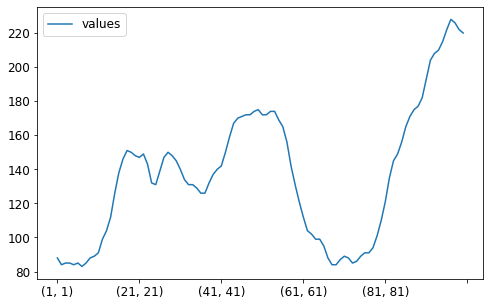

In [3]:
df.plot(figsize=(8,5))

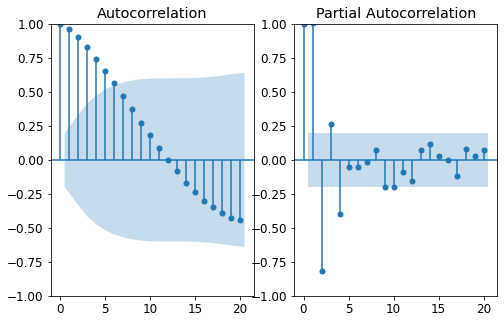

In [4]:
# Escoger parámetros de ARIMA

# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(df, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(df, ax=ax2, method='ols')

plt.show()

Se Puede ver que los datos que tenemos con respecto al tiempo no son estacionales, por lo que no nos podemos confíar en los valores dados, así que haremos la diferenciación.

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [6]:
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [7]:
# Ilustración del método differencing con pandas
ilustracion = pd.DataFrame()

ilustracion['real'] = df
ilustracion['1d'] = df.diff()
ilustracion['p=2'] = df.diff(periods=2)
ilustracion['2d'] = df.diff().diff()

diff1_values = df.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = df.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


La primera diferenciación nos dio un p-value mejor así que tomaremos esta.

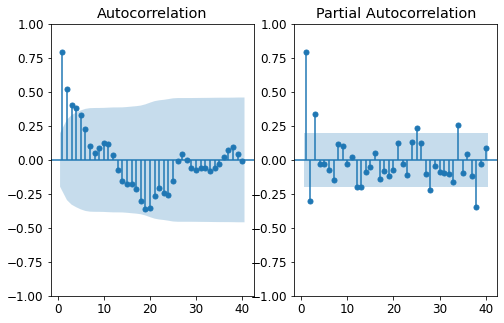

In [8]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':40})

Los valores de de p, d y q.

ARIMA(p=3, d=1, q=0)

In [9]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(df, order=(3, 1, 4))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -248.867
Date:                Tue, 06 Feb 2024   AIC                            513.734
Time:                        15:16:39   BIC                            534.495
Sample:                             0   HQIC                           522.134
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6208      0.146     11.092      0.000       1.334       1.907
ar.L2         -1.5418      0.172     -8.979      0.000      -1.878      -1.205
ar.L3          0.6287      0.137      4.577      0.0

Probaremos tambien con la segunda a ver si los valores nos dan mejores.

In [10]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(df, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:             ARIMA([2], 2, [2])   Log Likelihood                -256.198
Date:                Tue, 06 Feb 2024   AIC                            518.396
Time:                        15:16:39   BIC                            526.151
Sample:                             0   HQIC                           521.532
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.2090      0.240     -0.870      0.384      -0.680       0.262
ma.L2         -0.2188      0.238     -0.918      0.359      -0.686       0.248
sigma2        10.8799      1.740      6.253      0.0

Como podemos ver en los modelos ARIMA de las dos diferenciaciones nos da un mejor resultado con la primera firenciación ya que el Log liklihood es más grande que con la segunda diferenciación. Con el AIC y el BIC nos penalizó mucho el modelo por loq eu no se podría decir por medio de estas dos cual de los dos modelos es mejores, así que me iré más por el Log Likelihood.

### Ejercicio 2

En este usaremos el escalamiento de los datos para ver si los modelos de ARIMA mejoran con respecto a los del primer ejercicio.

In [11]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df))
scaled.head()

,0
0,0.034483
1,0.006897
2,0.013793
3,0.013793
4,0.006897


Con los datos ya escalados vemos si son estacionarios.

In [12]:
adf_test(scaled)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


No son esatcionarios así que vamos a ver como se ven.

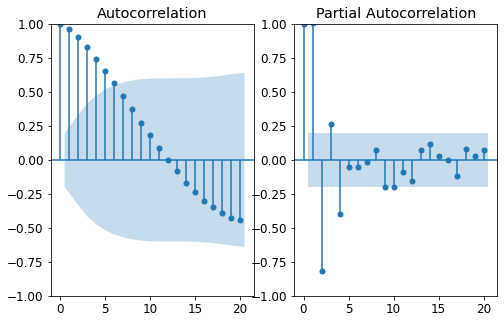

In [13]:
# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(scaled, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(scaled, ax=ax2, method='ols')

plt.show()

Ahora vamos a hacer las diferenciaciones de los datos escalados.

In [14]:
# Ilustración del método differencing con pandas
ilustracion = pd.DataFrame()

ilustracion['real'] = scaled
ilustracion['1d'] = scaled.diff()
ilustracion['p=2'] = scaled.diff(periods=2)
ilustracion['2d'] = scaled.diff().diff()

diff1_values = scaled.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = scaled.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


La segunda diferenciación si es estacionaria pero con un p-value muy bajo por lo que mejor usaremos la primera que tiene un p-value menor.

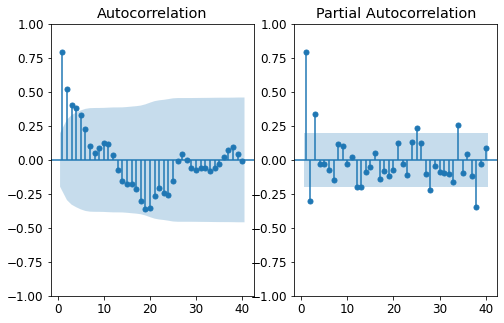

In [15]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':40})

Con lo datos escalados vemos que los valores de p,d,q son iguales a **Arima(p=1, d=1, q=1)**

In [16]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(scaled, order=(1, 1, 1))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 238.532
Date:                Tue, 06 Feb 2024   AIC                           -471.065
Time:                        15:16:44   BIC                           -463.279
Sample:                             0   HQIC                          -467.915
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6524      0.089      7.332      0.000       0.478       0.827
ma.L1          0.5109      0.090      5.700      0.000       0.335       0.687
sigma2         0.0005   6.68e-05      6.977      0.0

Podemos ver que el modelo de ARIMA mejoro mucho con respecto al del primer ejercicio, ya que los valores que nos dan son mucho mejores que los del primer ejercicio.

| |Log-Verosimilitud | AIC | BIC |
|---|---|---|---|
| Ejercicio 1 | -256.198 | 518.396 | 526.151 |
| Ejercicio 2 | 238.532 | -471.065 | -463.279 |

<AxesSubplot:>

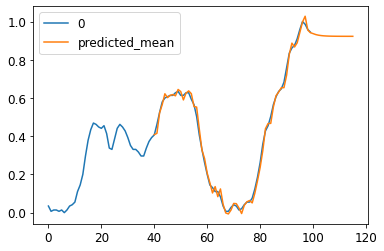

In [17]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model1.predict(start=40, end=115, dynamic=False).to_frame()

ax = scaled.plot()

y_h.plot(ax=ax)

Con la predicción se puede ver que si fue un buen modelo a comparación del ejercicio uno.

### Ejercicio 3 

Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:

In [18]:
import requests
from io import BytesIO
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import STL

air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
data2.head()

,air,time,t
1949-01-01,112,1949.000000,1.0
1949-02-01,118,1949.083374,2.0
1949-03-01,132,1949.166626,3.0
1949-04-01,129,1949.250000,4.0
1949-05-01,121,1949.333374,5.0


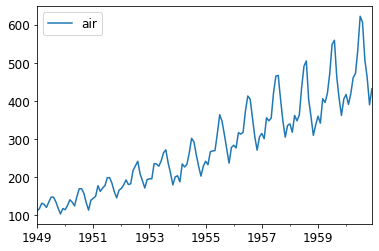

In [19]:
data2 = data2[["air"]]
data2.plot()
plt.show()

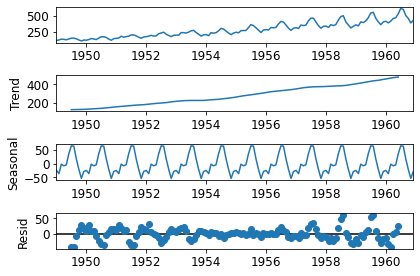

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data2, model="additive")
decompose_data.plot();

<AxesSubplot:>

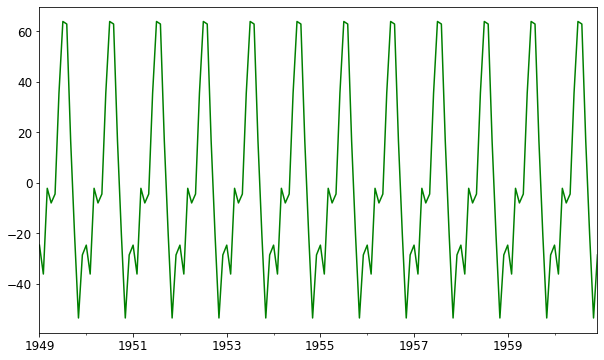

In [21]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green', figsize=(10,6))

In [22]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data2.air, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.8153688792060502
2. P-Value :  0.991880243437641
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


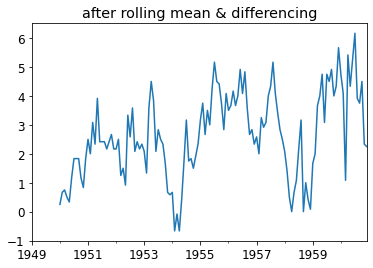

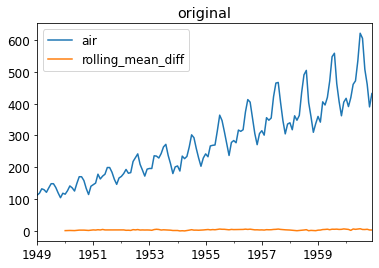

In [23]:
rolling_mean = data2.rolling(window = 12).mean()
data2['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data2['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data2.plot(title='original');

In [27]:
dftest = adfuller(data2['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -3.3830207264924783
2. P-Value :  0.011551493085515055
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


Como los modelos de ARIMA no funcionan de manera correcta con series estacionales se modificó el dataset para que se pudiera entrenar el modelo, nos dio que los valores de p,d,q son (1,1,1)

In [25]:
model=ARIMA(data2['air'],order=(1,1,1))
history=model.fit()

history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    air   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Tue, 06 Feb 2024   AIC                           1394.683
Time:                        15:16:53   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.000     751.362    1172.492
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.65   Prob(JB):                         0.34
Heteroskedasticity (H):               7.00   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Para el modelo de SARIMAX como este si sirve con series estacionales se uso el mismo orden que en el ARIMA (1,1,1) solo que en el seasonal order se le puso 12 que son los meses del año.

In [26]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(data2['air'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52844D+00    |proj g|=  8.65844D-02

At iterate    5    f=  3.52337D+00    |proj g|=  3.73532D-02

At iterate   10    f=  3.51577D+00    |proj g|=  4.96151D-03

At iterate   15    f=  3.51498D+00    |proj g|=  1.97082D-03

At iterate   20    f=  3.51493D+00    |proj g|=  6.86210D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   3.696D-05   3.515D+00
  F =   3.5149263674440223     

CONVERG

<AxesSubplot:>

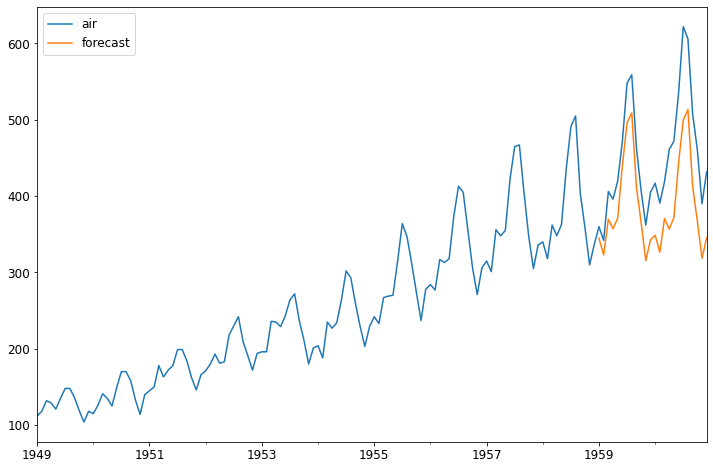

In [33]:
data2['forecast']=results.predict(start=120,end=180,dynamic=True)
data2[['air','forecast']].plot(figsize=(12,8))


Con esto podemos ver que el modelo SARIMAX se entreno de una manera correcta ya que su predicción con los datos dados son muy parecidas.

### Ejercicio 4

Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:


In [34]:
from pandas.tseries.offsets import DateOffset
pred_date=[data2.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [35]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data2.columns)
pred_date

,air,rolling_mean_diff,forecast
1961-01-01,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN


Se generaron datos nulos pero de tiempo más adelante a la que se tiene en nuestros datos para hacer una predicción de estos con el modelo SARIMAX

In [36]:
data=pd.concat([data2,pred_date])

<AxesSubplot:>

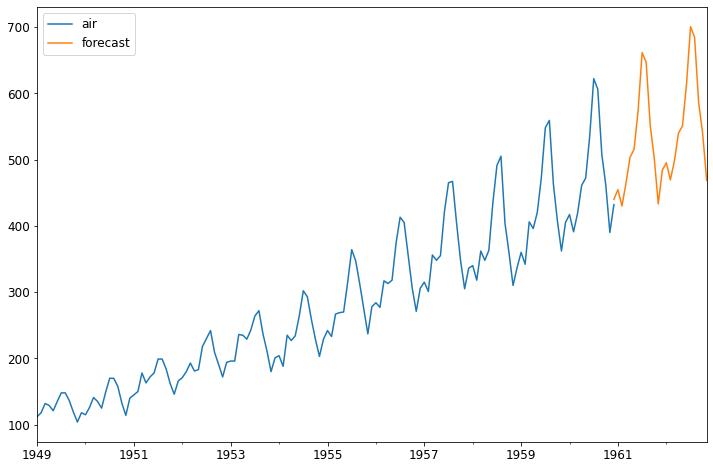

In [46]:
data['forecast'] = results.predict(start = 143, end = 200, dynamic= True)  
data[['air', 'forecast']].plot(figsize=(12, 8))

Podemos ver que la predicción sigue teniendo una tendencia estacional, por lo que es muy probable que la preddición con el modelo SARIMAX sea correcta.